In [109]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import sys
% matplotlib inline
import matplotlib.pyplot as plt
#sys.setdefaultencoding("utf-8")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Curri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Create list of stopwords from custom list and built-in library

In [214]:
from nltk.corpus import stopwords
ENGLISH_STOP_WORDS = set(stopwords.words('english'))
random_words = ["miss", "mr", "mrs", "said", "jr", "ms"]
nytimes_words = ["photo", "nytimes", "nytoday", "com", "www"]
custom_words = "___ saying hours told pareles news people like new thats le soho robert often chelsea fifth going scott john michael el time think saturday _____ briefing brantley bird rd give bleecker though nearly los bay dr side downtown theyre miller williams thcentury didnt dont central wife posted eastern want email red hook try take long summer winter minute long ago hour stories weekdays sundays rundown latest look sign let convention week american year say house york make know day late comedy host cbs report character guest night admission admissions charge fee johnson petrusich smith ratliff jersey staten chris daily manhattan wilson bronx cover reservations reservation dunning tickets tonight broadway chinen meeting japanese moses sponsored island information state united bowery little last also life much each two many tomorrow free org th minimum little Sonneh feet street man st door play one would years get even could way back around avenue streets says go really made something still got came come right always sanneh percent nd near co la sisario go says east village advance clinton san hes cotter made wa ha harlem de west thing sold another still around called things city see well beach men women woman man"
month_time_dayofweek = "january february march april may june july august september october november december sunday monday tuesday wednesday thursday friday morning noon night weekday weekend evening mondays tuesdays wednesdays thursdays fridays saturdays sundays jan feb mar aprl jun jul aug sep oct nov dec mon tues weds thurs fri sat sun pm month"
numbers_list = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"]
custom_words_list = custom_words.split()
month_time_day_list = month_time_dayofweek.split()

STOPLIST = set(stopwords.words('english') + random_words + numbers_list + list(month_time_day_list) + list(ENGLISH_STOP_WORDS) + nytimes_words + custom_words_list)
STOPLIST = list(STOPLIST)

##  Create dataframe, taking each corpus document and appending it to a column called "Contents"
**Note:each article was saved as an individual txt document with the date and URL in the file name 

In [3]:
path = 'corpus/williamsburg_finalcorpus'

myfolder = os.listdir(path)
articles = []

slash = '/'

for filename in myfolder:
    if filename.endswith('.txt'):
        date = filename[0:10]
        with open(path + slash + filename) as fh:
            contents = fh.read()
            articles.append([contents, date])
            
raw = pd.DataFrame(articles, columns=['Contents','Date'])
print(raw)


                                               Contents        Date
0     EVEN people with faith in nothing, people who ...  2000-01-02
1     Correction Appended\nTENEMENTS, yes. Luxury ho...  2000-01-06
2     Two years ago, Joe, the man I lived with, sugg...  2000-01-14
3     IF they didn't play their luck out in furnitur...  2000-01-20
4     FOR years, Tequila's on Columbus held out a we...  2000-01-26
5     At Relish, a gleaming silver diner on Wythe St...  2000-02-06
6     Correction Appended\nGO out in Brooklyn? On th...  2000-02-11
7     BACK in the 60's, ''commune'' was often synony...  2000-02-20
8     Correction Appended\nA half a century after a ...  2000-02-21
9     The Real Form Girdle building, once a gritty f...  2000-02-27
10    Jane Pierce, manager of the Hamilton Fish Publ...  2000-03-14
11    Old-Fashioned Confections At Columbus Flea Mar...  2000-03-15
12    LIMOR TOMER, a Juilliard-trained pianist and f...  2000-03-26
13    THESE are among my favorite new restaurant

### Drop duplicates

In [4]:
raw_no_duplicates = raw.drop_duplicates("Contents")
raw_no_duplicates

,Contents,Date
0,"EVEN people with faith in nothing, people who ...",2000-01-02
1,"Correction Appended\nTENEMENTS, yes. Luxury ho...",2000-01-06
2,"Two years ago, Joe, the man I lived with, sugg...",2000-01-14
3,IF they didn't play their luck out in furnitur...,2000-01-20
4,"FOR years, Tequila's on Columbus held out a we...",2000-01-26
5,"At Relish, a gleaming silver diner on Wythe St...",2000-02-06
6,Correction Appended\nGO out in Brooklyn? On th...,2000-02-11
7,"BACK in the 60's, ''commune'' was often synony...",2000-02-20
8,Correction Appended\nA half a century after a ...,2000-02-21
9,"The Real Form Girdle building, once a gritty f...",2000-02-27


### Generate new rows for month and year

In [71]:
raw_no_duplicates["Contents_Lower"] = raw_no_duplicates["Contents"].str.lower()
raw_no_duplicates["Contents_Clean"] = raw_no_duplicates["Contents_Lower"].apply(lambda x: x.replace("\n", " "))
raw_no_duplicates["Year"] = raw_no_duplicates["Date"].astype(str).str[0:4]
raw_no_duplicates["Month"] = raw_no_duplicates["Date"].astype(str).str[5:7]
raw_no_duplicates["Date_by_Month"] = raw_no_duplicates["Month"].map(str) + '-' + raw_no_duplicates["Year"].map(str)

C:\Users\Curri\Miniconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Curri\Miniconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Curri\Miniconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

,Contents,Date,Contents_Lower,Contents_Clean,Year,Month,Contents_nopunc,Contents_Tokenized,Contents_decode,Contents_Lemma,Date_by_Month
0,"EVEN people with faith in nothing, people who ...",2000-01-02,"even people with faith in nothing, people who ...","even people with faith in nothing, people who ...",2000,01,even people with faith in nothing people who b...,"[even, people, with, faith, in, nothing, peopl...","[even, people, with, faith, in, nothing, peopl...",even people with faith in nothing people who b...,01-2000
1,"Correction Appended\nTENEMENTS, yes. Luxury ho...",2000-01-06,"correction appended\ntenements, yes. luxury ho...","correction appended tenements, yes. luxury hou...",2000,01,correction appended tenements yes luxury housi...,"[correction, appended, tenements, yes, luxury,...","[correction, appended, tenements, yes, luxury,...",correction appended tenement yes luxury housin...,01-2000
2,"Two years ago, Joe, the man I lived with, sugg...",2000-01-14,"two years ago, joe, the man i lived with, sugg...","two years ago, joe, the man i lived with, sugg...",2000,01,two years ago joe the man i lived with suggest...,"[two, years, ago, joe, the, man, i, lived, wit...","[two, years, ago, joe, the, man, i, lived, wit...",two year ago joe the man i lived with suggeste...,01-2000
3,IF they didn't play their luck out in furnitur...,2000-01-20,if they didn't play their luck out in furnitur...,if they didn't play their luck out in furnitur...,2000,01,if they didnt play their luck out in furniture...,"[if, they, didnt, play, their, luck, out, in, ...","[if, they, didnt, play, their, luck, out, in, ...",if they didnt play their luck out in furniture...,01-2000
4,"FOR years, Tequila's on Columbus held out a we...",2000-01-26,"for years, tequila's on columbus held out a we...","for years, tequila's on columbus held out a we...",2000,01,for years tequilas on columbus held out a welc...,"[for, years, tequilas, on, columbus, held, out...","[for, years, tequilas, on, columbus, held, out...",for year tequila on columbus held out a welcom...,01-2000
5,"At Relish, a gleaming silver diner on Wythe St...",2000-02-06,"at relish, a gleaming silver diner on wythe st...","at relish, a gleaming silver diner on wythe st...",2000,02,at relish a gleaming silver diner on wythe str...,"[at, relish, a, gleaming, silver, diner, on, w...","[at, relish, a, gleaming, silver, diner, on, w...",at relish a gleaming silver diner on wythe str...,02-2000
6,Correction Appended\nGO out in Brooklyn? On th...,2000-02-11,correction appended\ngo out in brooklyn? on th...,correction appended go out in brooklyn? on the...,2000,02,correction appended go out in brooklyn on the ...,"[correction, appended, go, out, in, brooklyn, ...","[correction, appended, go, out, in, brooklyn, ...",correction appended go out in brooklyn on the ...,02-2000
7,"BACK in the 60's, ''commune'' was often synony...",2000-02-20,"back in the 60's, ''commune'' was often synony...","back in the 60's, ''commune'' was often synony...",2000,02,back in the s commune was often synonymous wit...,"[back, in, the, s, commune, was, often, synony...","[back, in, the, s, commune, was, often, synony...",back in the s commune wa often synonymous with...,02-2000
8,Correction Appended\nA half a century after a ...,2000-02-21,correction appended\na half a century after a ...,correction appended a half a century after a p...,2000,02,correction appended a half a century after a p...,"[correction, appended, a, half, a, century, af...","[correction, appended, a, half, a, century, af...",correction appended a half a century after a p...,02-2000
9,"The Real Form Girdle building, once a gritty f...",2000-02-27,"the real form girdle building, once a gritty f...","the real form girdle building, once a gritty f...",2000,02,the real form girdle building once a gritty fa...,"[the, real, form, girdle, building, once, a, g...","[the, real, form, girdle, building, once, a, g...",the real form girdle building once a gritty fa...,

### Clean and preprocess text by: removing digits, stop words, and punctuation. Then tokenize words and lemmatize for analysis

In [42]:
import string
exclude = set(string.punctuation)

def is_good_utf8(str):
    try:
        str.decode("utf-8")
        return True
    except:
        return False
    
raw_no_duplicates["Contents_Clean"] = raw_no_duplicates["Contents_Clean"].apply(lambda x: ''.join([c for c in x if not c.isdigit()]))
raw_no_duplicates["Contents_nopunc"] = raw_no_duplicates["Contents_Clean"].apply(lambda x: ''.join([c for c in x if c not in exclude]))
raw_no_duplicates['Contents_Tokenized']=raw_no_duplicates["Contents_nopunc"].apply(lambda x : filter(is_good_utf8, filter(None,x.split(" "))))
raw_no_duplicates['Contents_decode']=raw_no_duplicates['Contents_Tokenized'].apply(lambda x: [word.decode('utf-8', ) for word in x])
raw_no_duplicates["Contents_Lemma"]=raw_no_duplicates["Contents_decode"].apply(lambda x : " ".join(lemma.lemmatize(word) for word in x))



C:\Users\Curri\Miniconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [43]:
raw_no_duplicates

,Contents,Date,Contents_Lower,Contents_Clean,Year,Month,Contents_nopunc,Contents_Tokenized,Contents_decode,Contents_Lemma
0,"EVEN people with faith in nothing, people who ...",2000-01-02,"even people with faith in nothing, people who ...","even people with faith in nothing, people who ...",2000,01,even people with faith in nothing people who b...,"[even, people, with, faith, in, nothing, peopl...","[even, people, with, faith, in, nothing, peopl...",even people with faith in nothing people who b...
1,"Correction Appended\nTENEMENTS, yes. Luxury ho...",2000-01-06,"correction appended\ntenements, yes. luxury ho...","correction appended tenements, yes. luxury hou...",2000,01,correction appended tenements yes luxury housi...,"[correction, appended, tenements, yes, luxury,...","[correction, appended, tenements, yes, luxury,...",correction appended tenement yes luxury housin...
2,"Two years ago, Joe, the man I lived with, sugg...",2000-01-14,"two years ago, joe, the man i lived with, sugg...","two years ago, joe, the man i lived with, sugg...",2000,01,two years ago joe the man i lived with suggest...,"[two, years, ago, joe, the, man, i, lived, wit...","[two, years, ago, joe, the, man, i, lived, wit...",two year ago joe the man i lived with suggeste...
3,IF they didn't play their luck out in furnitur...,2000-01-20,if they didn't play their luck out in furnitur...,if they didn't play their luck out in furnitur...,2000,01,if they didnt play their luck out in furniture...,"[if, they, didnt, play, their, luck, out, in, ...","[if, they, didnt, play, their, luck, out, in, ...",if they didnt play their luck out in furniture...
4,"FOR years, Tequila's on Columbus held out a we...",2000-01-26,"for years, tequila's on columbus held out a we...","for years, tequila's on columbus held out a we...",2000,01,for years tequilas on columbus held out a welc...,"[for, years, tequilas, on, columbus, held, out...","[for, years, tequilas, on, columbus, held, out...",for year tequila on columbus held out a welcom...
5,"At Relish, a gleaming silver diner on Wythe St...",2000-02-06,"at relish, a gleaming silver diner on wythe st...","at relish, a gleaming silver diner on wythe st...",2000,02,at relish a gleaming silver diner on wythe str...,"[at, relish, a, gleaming, silver, diner, on, w...","[at, relish, a, gleaming, silver, diner, on, w...",at relish a gleaming silver diner on wythe str...
6,Correction Appended\nGO out in Brooklyn? On th...,2000-02-11,correction appended\ngo out in brooklyn? on th...,correction appended go out in brooklyn? on the...,2000,02,correction appended go out in brooklyn on the ...,"[correction, appended, go, out, in, brooklyn, ...","[correction, appended, go, out, in, brooklyn, ...",correction appended go out in brooklyn on the ...
7,"BACK in the 60's, ''commune'' was often synony...",2000-02-20,"back in the 60's, ''commune'' was often synony...","back in the 's, ''commune'' was often synonymo...",2000,02,back in the s commune was often synonymous wit...,"[back, in, the, s, commune, was, often, synony...","[back, in, the, s, commune, was, often, synony...",back in the s commune wa often synonymous with...
8,Correction Appended\nA half a century after a ...,2000-02-21,correction appended\na half a century after a ...,correction appended a half a century after a p...,2000,02,correction appended a half a century after a p...,"[correction, appended, a, half, a, century, af...","[correction, appended, a, half, a, century, af...",correction appended a half a century after a p...
9,"The Real Form Girdle building, once a gritty f...",2000-02-27,"the real form girdle building, once a gritty f...","the real form girdle building, once a gritty f...",2000,02,the real form girdle building once a gritty fa...,"[the, real, form, girdle, building, once, a, g...","[the, real, form, girdle, building, once, a, g...",the real form girdle building once a gritty fa...


### Generate NMF and LDA Outputs

In [215]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation


tfidf_vectorizer = TfidfVectorizer(max_df = 0.4, min_df = 15,
                                   stop_words = STOPLIST)
tfidf = tfidf_vectorizer.fit_transform(raw_no_duplicates["Contents_Lemma"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf = NMF(n_components = 10, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

In [216]:
#function to display the topics and terms that make up each topic for both models -- will be called at the end

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [217]:

#LDA Model
no_features = 1000

#specify number of topic words
no_top_words = 20
no_topics = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=STOPLIST)
tf = tf_vectorizer.fit_transform(raw_no_duplicates["Contents_Lemma"])
tf_feature_names = tf_vectorizer.get_feature_names()
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)




C:\Users\Curri\Miniconda2\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [184]:
transformed_data = nmf.transform(tfidf)
len(transformed_data)

1477

In [297]:
transformed_data_lda = lda.transform(tf)

In [218]:
print_top_words(nmf, tfidf_feature_names, 10)

Topic #0:
band song album rock guitar ballroom pop hall singer theater
Topic #1:
store friend business shop artist rent party apartment school company
Topic #2:
museum painting gallery artist exhibition sculpture photograph drawing image object
Topic #3:
dance ticket ballet opera theater program company choreographer dancer performance
Topic #4:
tour museum student child exhibition garden walking corner walk history
Topic #5:
jazz ticket band saxophonist song drummer pianist trio bassist quartet
Topic #6:
restaurant chef wine menu food dish beer diner opened burger
Topic #7:
post mayor bloomberg school police official authority department officer council
Topic #8:
apartment developer housing development price unit project market million buyer
Topic #9:
theater preview musical production directs cast close stage drama revival
()


In [219]:
print_top_words(lda, tf_feature_names, no_top_words)


Topic #0:
theater show film musical open preview story movie production director close stage cast begin festival book music young actor star
Topic #1:
park tour museum child student brooklyn garden exhibition member center art lower history place open society corner walk walking square
Topic #2:
band music song rock album record show club brooklyn first pop sound party group hiphop guitar label fan black since
Topic #3:
artist art space neighborhood party work studio gallery place friend gay brooklyn young loft live hipster rent area scene book
Topic #4:
bar restaurant brooklyn coffee food place beer wine drink owner good opened room chef menu hotel open cocktail shop first
Topic #5:
building apartment brooklyn neighborhood development million price market housing area project plan park space school developer real home estate rent
Topic #6:
art museum show work artist gallery painting exhibition sculpture drawing photograph image contemporary modern collection design object close video

In [256]:
def zero_equals_1(x): 
    if x != 0:
        return 1
    else:
        return x

In [257]:
transformed_data = pd.DataFrame(transformed_data)
article_topics = transformed_data.applymap(zero_equals_1)
raw_data = raw_no_duplicates.reset_index()
article_topics["Date"] = raw_data["Date_by_Month"]
article_topics["Year"] = raw_data["Year"]
article_topics["Article_Num"] = range(1, len(article_topics) + 1)
melted_df = pd.melt(article_topics, id_vars = ["Article_Num", "Date", "Year"], var_name = "Topic_Num")

In [258]:
melted_df = melted_df[-melted_df["Topic_Num"].isin([0, 26])]

In [259]:
#NMF Topic Names
NMF_Topic_Names = {1: "Live Music",
               2: "Neighborhood Life",
               3: "Galleries and Art Exhibitions",
               4: "Dance & Theater",
               5: "Tours & Tourism",
               6: "Jazz consumption",
               7: "Food & Restaurant Culture",
               8: "Public Safety", 
               9: "Residential Development", 
              10: "Entertainment Production"}

In [260]:
#NMF Topic Names
LDA_Topic_Names = {1: "Entertainment Production",
               2: "Tours & Tourism",
               3: "Music Consumption",
               4: "Neighborhood Culture",
               5: "Dining Out",
               6: "Real Estate Development",
               7: "Galleries & Art Exhibitions",
               8: "Fashion & Retail", 
               9: "Live Music", 
              10: "Dance & Theater"}

In [261]:
topic_num_to_name = pd.DataFrame.from_dict(NMF_Topic_Names, orient = "index").reset_index()
topic_num_to_name.columns = ["Topic_Num", "NMF_Topic_Name"]
final_df = melted_df.merge(topic_num_to_name, on = "Topic_Num")

In [268]:
#OVERALL NMF TOPICS
overall_NMF_topic = pd.DataFrame({"Entertainment & Leisure": [1,3,4,6,7,10],
                     "Neighborhood Development": [2,5,8,9,"Nan","Nan"]})
melted_ot = pd.melt(overall_NMF_topic)
melted_ot = melted_ot[melted_ot["value"] != "NaN"]
melted_ot.columns = ["NMF Overall Topic", "Topic_Num"]

In [284]:
final_df = final_df.merge(melted_ot, on = "Topic_Num")

In [271]:
final_df = final_df.groupby(["Year", "Topic_Num", "NMF_Topic_Name", "NMF Overall Topic"]).sum().reset_index()

In [274]:
# import calendar
# def extract_month_year(date):
#     month = int(date[0:2])
#     month_name = calendar.month_name[month]
#     year = int(date[2:])
#     return month_name + " " + str(year)

In [275]:
# melted_df["Month_Year"] = melted_df["Date"].apply(lambda x: extract_month_year(x))

In [276]:
final_df = final_df.rename(columns={'NMF_Topic_Name': 'NMF Topic Name'})

In [278]:
# final_df['Month_Year'] = final_df['Month_Year'].str.replace('-',' ')
# final_df

In [240]:
order = ["2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010"]

[Text(0,0.5,u'Number of Articles'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Neighborhood Development')]

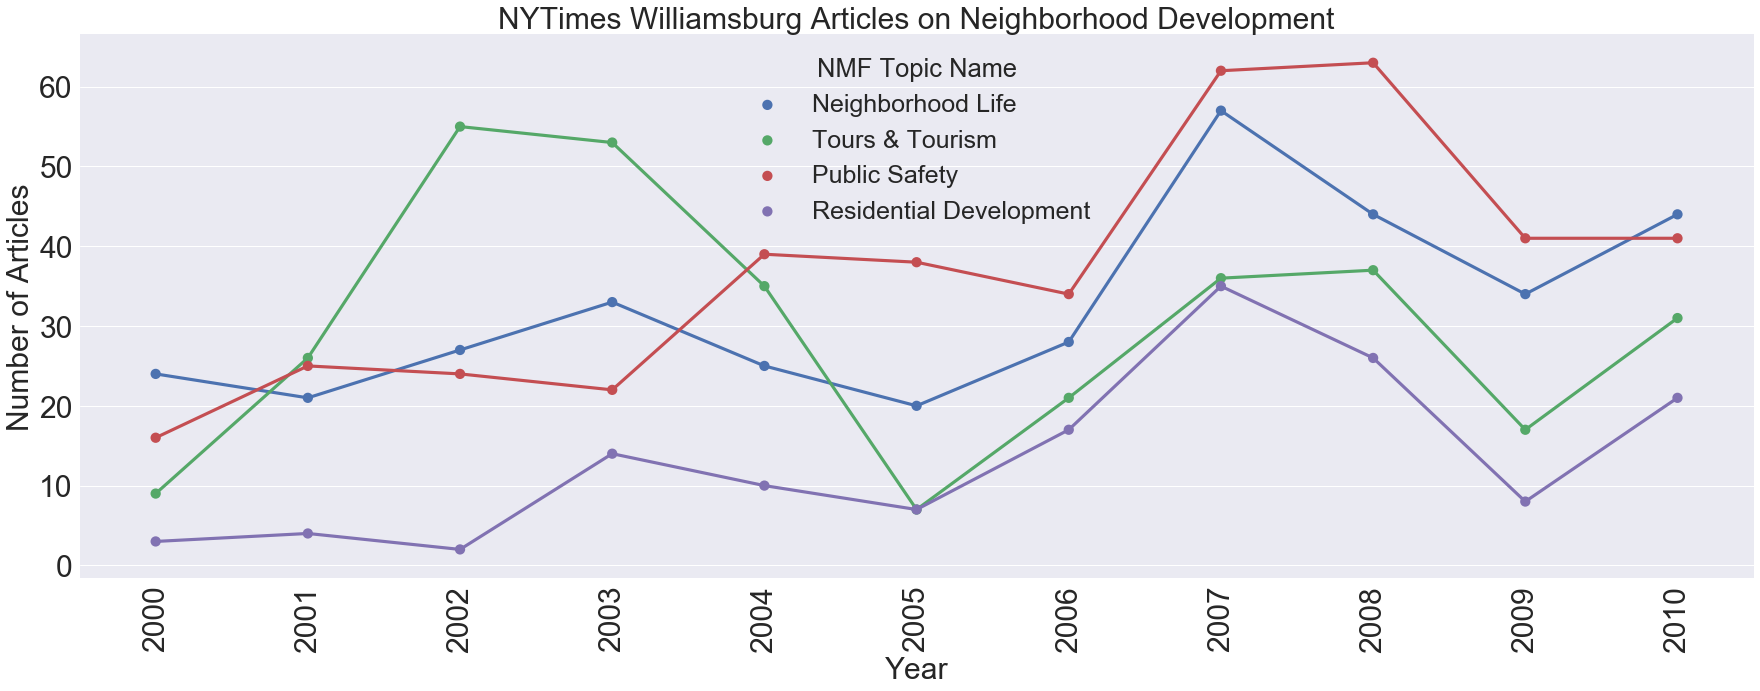

In [282]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = final_df[final_df["NMF Overall Topic"] == "Neighborhood Development"]
g = sns.pointplot(ci = None, x = one_topic["Year"], y = one_topic["value"], order = order, hue = one_topic["NMF Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Number of Articles", title = "NYTimes Williamsburg Articles on Neighborhood Development")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')

[Text(0,0.5,u'Number of Articles'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Entertainment & Leisure')]

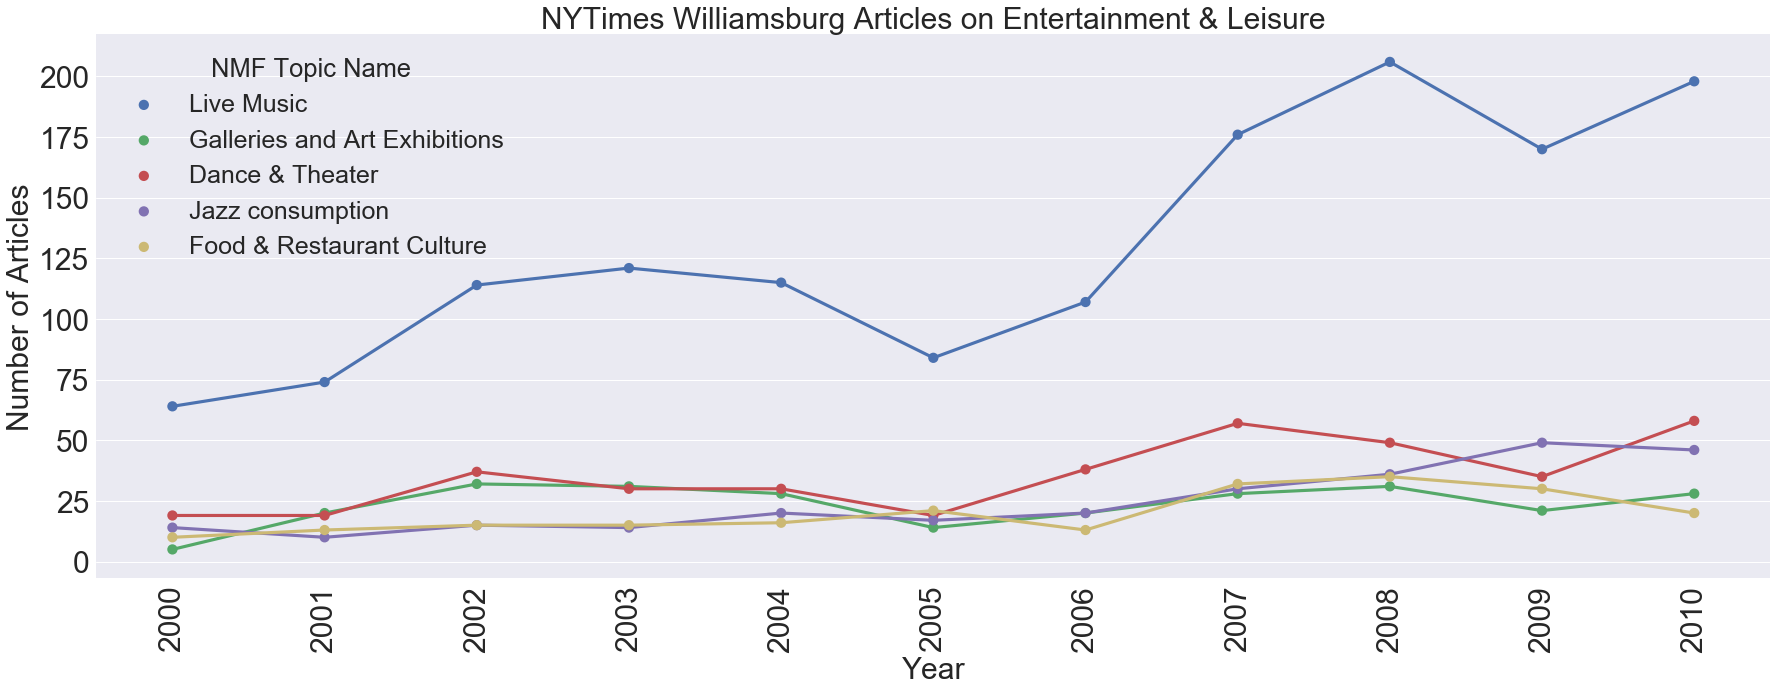

In [283]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = final_df[final_df["NMF Overall Topic"] == "Entertainment & Leisure"]
g = sns.pointplot(ci = None, x = one_topic["Year"], y = one_topic["value"], order = order, hue = one_topic["NMF Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Number of Articles", title = "NYTimes Williamsburg Articles on Entertainment & Leisure")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')

In [299]:
transformed_data_LDA = pd.DataFrame(transformed_data_lda)
article_topics_LDA = transformed_data_LDA.applymap(zero_equals_1)
raw_data = raw_no_duplicates.reset_index()
article_topics_LDA["Date"] = raw_data["Date_by_Month"]
article_topics_LDA["Year"] = raw_data["Year"]
article_topics_LDA["Article_Num"] = range(1, len(article_topics) + 1)
melted_df = pd.melt(article_topics_LDA, id_vars = ["Article_Num", "Date", "Year"], var_name = "Topic_Num")

In [300]:
melted_df = melted_df[-melted_df["Topic_Num"].isin([0, 26])]

In [301]:
topic_num_to_name_LDA = pd.DataFrame.from_dict(LDA_Topic_Names, orient = "index").reset_index()
topic_num_to_name_LDA.columns = ["Topic_Num", "LDA_Topic_Name"]
final_df_LDA = melted_df.merge(topic_num_to_name_LDA, on = "Topic_Num")

In [302]:
#OVERALL LDA TOPICS
overall_LDA_topic = pd.DataFrame({"Entertainment & Leisure": [1,3,5,7,9,10],
                     "Neighborhood Development": [2,4,6,8,"Nan","Nan"]})
melted_ot_LDA = pd.melt(overall_LDA_topic)
melted_ot_LDA = melted_ot[melted_ot_LDA["value"] != "NaN"]
melted_ot_LDA.columns = ["LDA Overall Topic", "Topic_Num"]

In [303]:
final_df_LDA = final_df_LDA.merge(melted_ot_LDA, on = "Topic_Num")

In [304]:
final_df_LDA = final_df_LDA.groupby(["Year", "Topic_Num", "LDA_Topic_Name", "LDA Overall Topic"]).sum().reset_index()

[Text(0,0.5,u'Number of Articles'),
 Text(0.5,0,u'Year'),
 Text(0.5,1,u'NYTimes Williamsburg Articles on Neighborhood Development')]

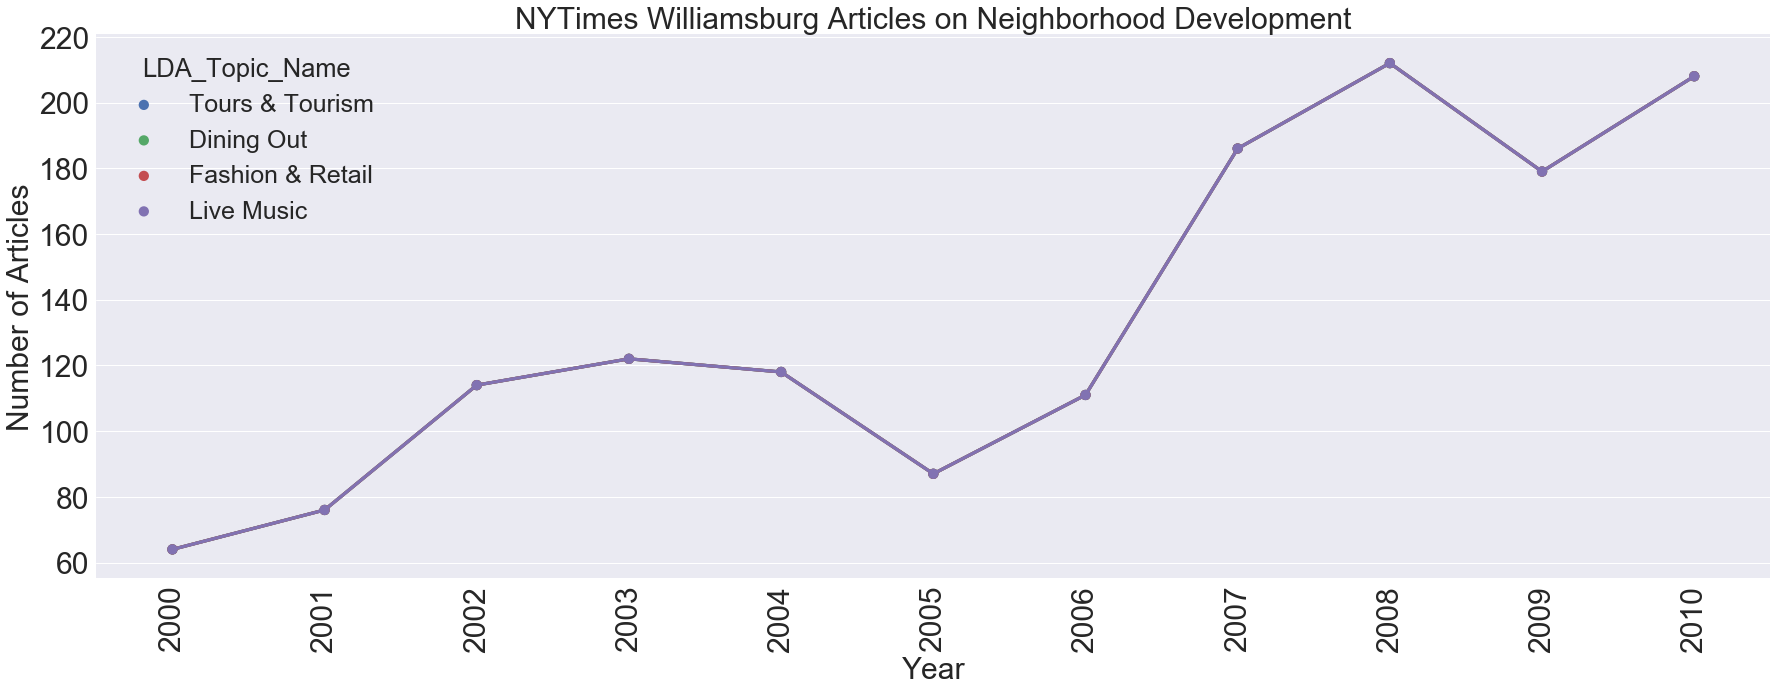

In [305]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = final_df_LDA[final_df_LDA["LDA Overall Topic"] == "Neighborhood Development"]
g = sns.pointplot(ci = None, x = one_topic["Year"], y = one_topic["value"], order = order, hue = one_topic["LDA_Topic_Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Year", ylabel = "Number of Articles", title = "NYTimes Williamsburg Articles on Neighborhood Development")
# plt.savefig("Policy_Articles.png", bbox_inches='tight')